In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ctext-clustering/ctext clustering.xlsx


## EDA

In [2]:
df = pd.read_excel("/kaggle/input/ctext-clustering/ctext clustering.xlsx")

In [3]:
df.head(10)

,Id,Comment
0,0x840,A few things. You might have negative- frequen...
1,0xbf0,Is it so hard to believe that there exist part...
2,0x1dfc,There are bees
3,0xc7e,I'm a medication technician. And that's alot o...
4,0xbba,Cesium is such a pretty metal.
5,0xb39,I meant that the question itself is unclear.
6,0x1f3d,Shove it up your ass and see what happens
7,0x531,"??? I mean it has some butter, but besides tha..."
8,0xe05,https://t.me/joinchat/3gElLHLuMCxhNGI0
9,0x2148,"Well, thatâ€™s just the thing. You canâ€™t rea..."


In [4]:
df[10:20]

,Id,Comment
10,0xc19,Is H2S what produced when the egg protein is ...
11,0x2651,And the mRNA would have to have a specific pro...
12,0xd2,He's probably just really torn up about the Dr...
13,0xf83,Has this helped you with the 4.8% value tho?
14,0x1aab,"Not ""free"" elections, but it's what is called ..."
15,0x27de,This post was brought to you by VINEGAR! IT C...
16,0xaf2,Realistically youâ€™d be better off just buyin...
17,0x1386,"Hey, youâ€™ll get there one day."
18,0x31c,There's also a glorious spy device which uses ...
19,0x23f,"Their gills collapse in the air, stick togethe..."


In [5]:
df.shape

(8695, 2)

Data masih dalam bentuk kotor dan harus dibersihkan

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8695 entries, 0 to 8694
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       8695 non-null   object
 1   Comment  8693 non-null   object
dtypes: object(2)
memory usage: 136.0+ KB


In [7]:
df['Comment'].isna().sum()

2

Missing value tidak terlalu banyak maka ada baiknya untuk drop missing value

In [8]:
df.dropna(inplace=True)

In [9]:
df.shape

(8693, 2)

Setelah melihat data, saya juga menemukan adanyak record cengna comment berupa [remove] hal ini harus di remove karena tidak memberikan insight apapun terhadap

In [10]:
df['Comment'] = df['Comment'].replace('[removed]', pd.NA)
df['Comment'].isna().sum()

114

Bisa dilihat terdapat 114 comment yang hanya berisi [removed]

In [11]:
df.dropna(subset=['Comment'], inplace=True)

In [12]:
df['Comment'].isna().sum()

0

In [13]:
df.shape

(8579, 2)

## Text Preprocessing

In [14]:
import re

In [15]:
def cleansing(df):
    # Mengubah menjadi lowercase
    df_clean = df.str.lower()

    # Menghapus URL
    df_clean = [re.sub(r'http\S+', '', i) for i in df_clean]

    # Menhapus mention (@random)
    df_clean = [re.sub(r'@[\w_]+', '', i) for i in df_clean]

    # Menghapus hashtag
    df_clean = [re.sub(r'#', '', i) for i in df_clean]

    # Menghapus angka
    df_clean = [re.sub(r'\d+', '', i) for i in df_clean]

    # Menghapus non-word characters 
    df_clean = [re.sub(r'[^\w\s]', ' ', i) for i in df_clean]
    
    #Menghapus Symbol
    df_clean = [re.sub(r'[^a-zA-Z0-9\s]', '', i) for i in df_clean]

    # Menghapus extra whitespaces
    df_clean = [re.sub(r'\s+', ' ', i).strip() for i in df_clean]

    return df_clean

Mengubah Kolom comment dataype menjadi string agar bisa diproses

In [16]:
df['Comment'] = df['Comment'].astype(str)

In [17]:
df_cleaned = cleansing(df['Comment'])

In [18]:
df_cleaned[0:10]

['a few things you might have negative frequency dependent selection going on where the least common phenotype reflected by genotype is going to have an advantage in the environment for instance if a prey animal such as a vole were to have a light and a dark phenotype a predator might recognize the more common phenotype as food so if the light voles are more common foxes may be keeping a closer eye out for light phenotypic voles recognising them as good prey this would reduce the light causing alleles due to increased predation and the dark genotypes would increase their proportion of the population until this scenario is reversed this cycle continues perpetually n nhowever this is unlikely to be strictly yearly as it usually takes more time than a year for an entire populations allele frequencies to change enough to make a large enough difference to alter fitness n nmore likely on a year to year basis the population is experiencing fluctuating selection where alternating conditions in

### Stopword Removal and Vectoriation

Menggunakan TF-IDF sebagai text representation dan KMeansClustering sebagai model.

In [19]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_cleaned)

In [21]:
X

<8579x16513 sparse matrix of type '<class 'numpy.float64'>'
	with 103288 stored elements in Compressed Sparse Row format>

In [22]:
number_of_clusters = 10
model = KMeans(n_clusters=number_of_clusters, 
               init='k-means++', 
               max_iter=100, 
               n_init=1)
model.fit(X)

KMeans(max_iter=100, n_clusters=10, n_init=1)

In [23]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

Berikut merupakan 10 kata yang sering kerluar untuk setiap kluster

In [24]:
for i in range(number_of_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 thank
 thanks
 deleted
 yes
 did
 answer
 does
 bug
 right
 mean
Cluster 1:
 just
 like
 don
 let
 use
 probably
 water
 really
 make
 way
Cluster 2:
 lol
 like
 got
 just
 joke
 hear
 ok
 good
 don
 exactly
Cluster 3:
 think
 time
 don
 people
 question
 just
 energy
 actually
 ve
 like
Cluster 4:
 isn
 true
 just
 people
 really
 thing
 like
 chance
 probably
 yes
Cluster 5:
 know
 don
 eat
 didn
 just
 want
 like
 right
 people
 let
Cluster 6:
 ll
 yeah
 thanks
 read
 thank
 time
 don
 like
 try
 sure
Cluster 7:
 thought
 ok
 thank
 thanks
 cream
 just
 question
 ice
 cool
 oh
Cluster 8:
 good
 water
 way
 make
 sure
 chemistry
 really
 people
 need
 pretty
Cluster 9:
 like
 looks
 sounds
 look
 seen
 does
 doesn
 just
 sound
 bug


In [25]:
inertia = model.inertia_
print("Inertia:", inertia)

Inertia: 8326.712981468165


In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


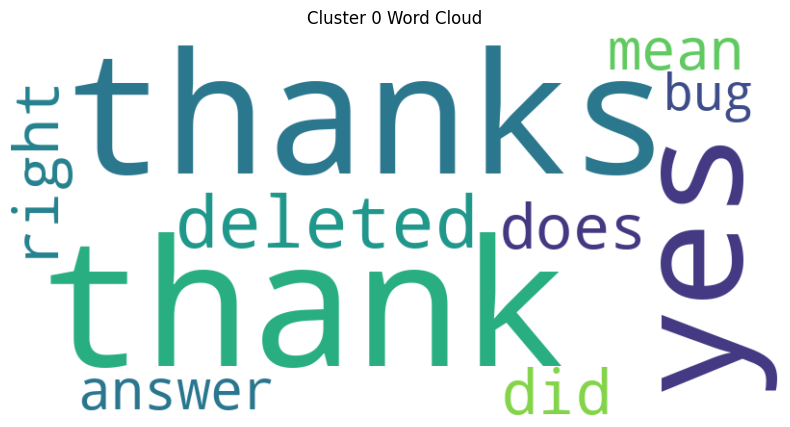

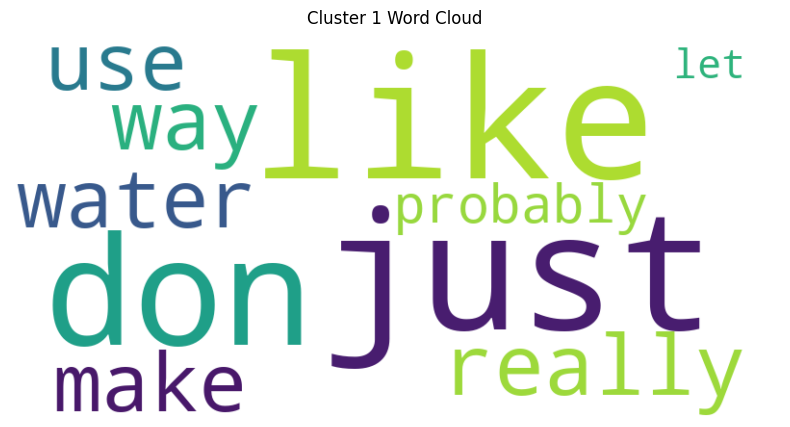

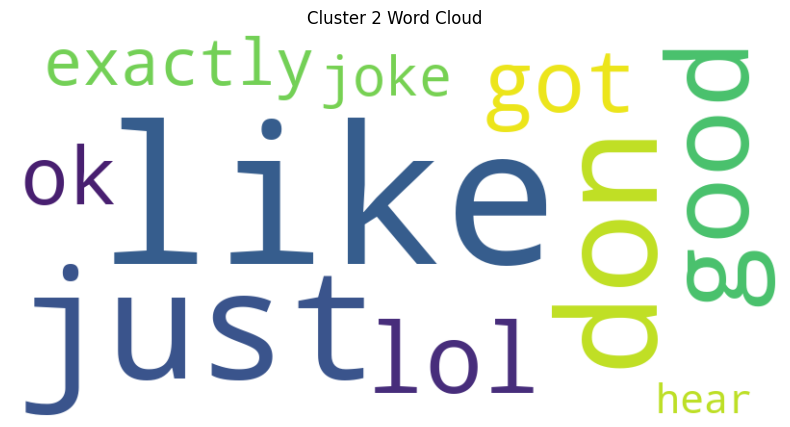

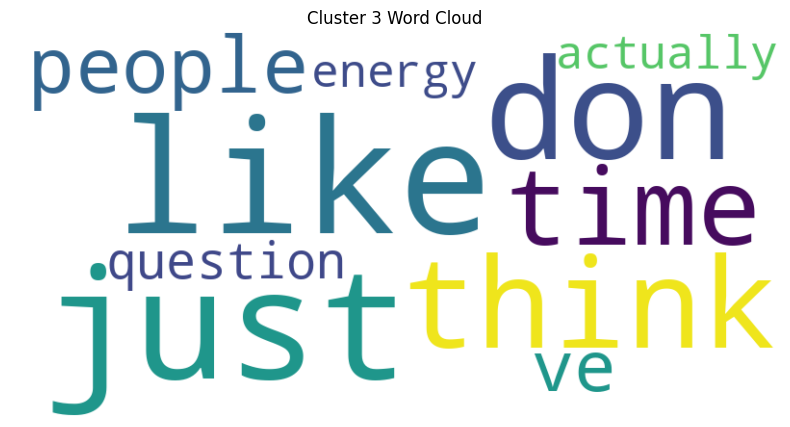

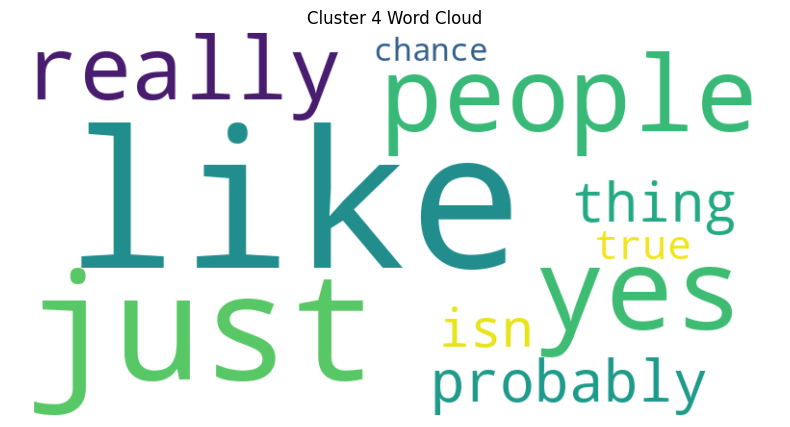

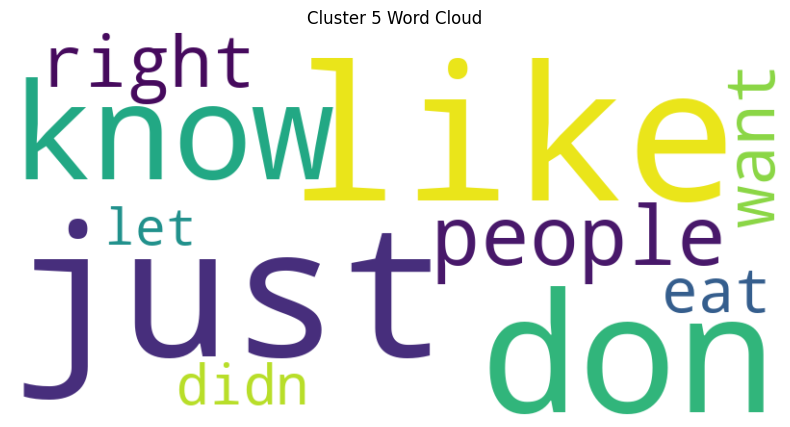

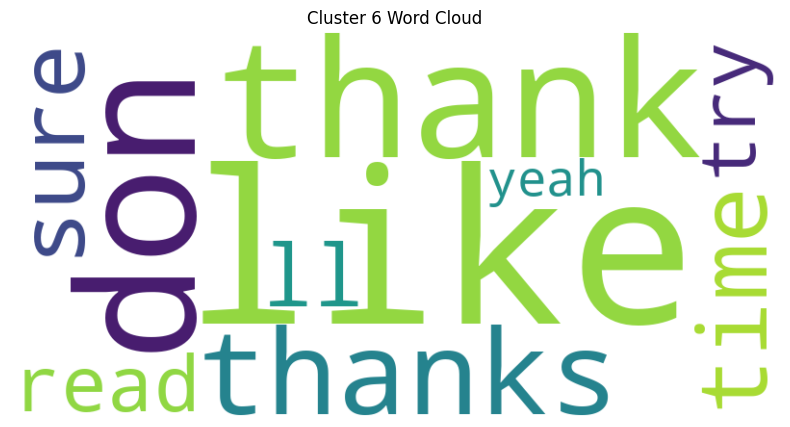

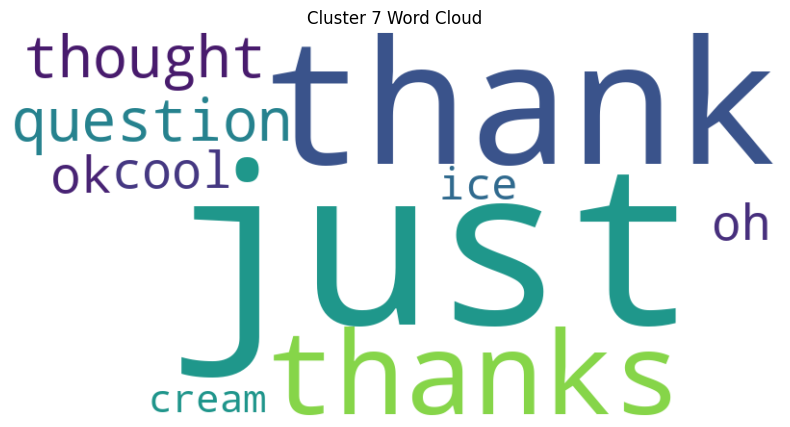

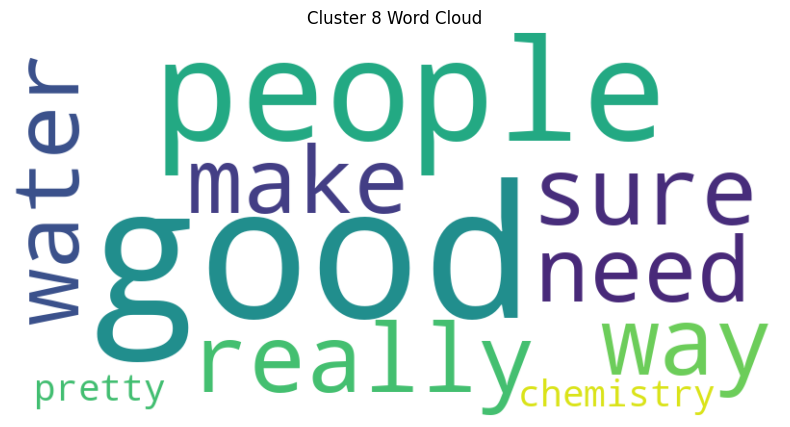

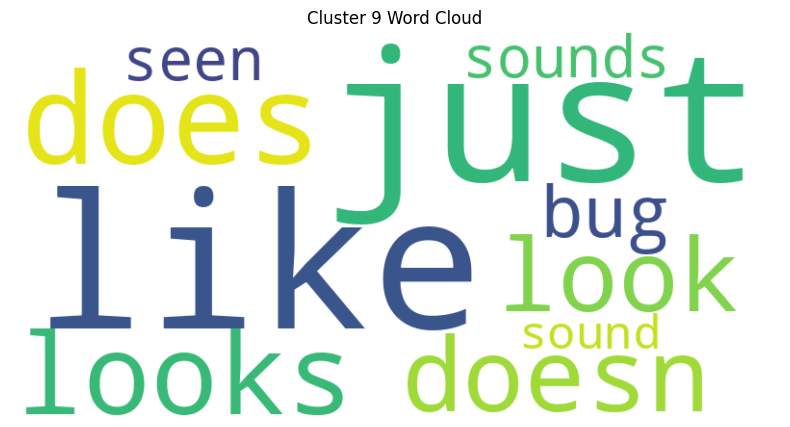

In [27]:
for i in range(number_of_clusters):
    # Get the indices of the top terms in the cluster
    top_indices = model.cluster_centers_.argsort()[i, ::-1][:10]
    
    # Get the feature names from the vectorizer
    feature_names = vectorizer.get_feature_names_out()
    
    # Create a dictionary of term frequencies in the cluster
    wordcloud_dict = {feature_names[ind]: X[:, ind].sum() for ind in top_indices}
    
    # Create and plot the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_dict)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {i} Word Cloud')
    plt.axis('off')
    plt.show()

Mencoba menggunakan kluster yang lebih banyak

In [29]:
from sklearn.metrics import silhouette_score

In [30]:
for n_clusters in range(2, 11):
    model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1, random_state=42)
    model.fit(X)
    silhouette_avg = silhouette_score(X, model.labels_)
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg}")

Number of clusters: 2, Silhouette Score: 0.0033614717543152574
Number of clusters: 3, Silhouette Score: 0.0036232106267289283
Number of clusters: 4, Silhouette Score: 0.003873221837486735
Number of clusters: 5, Silhouette Score: 0.004627836088186142
Number of clusters: 6, Silhouette Score: 0.005486553940420536
Number of clusters: 7, Silhouette Score: 0.005764040350598584
Number of clusters: 8, Silhouette Score: -0.005455133282024531
Number of clusters: 9, Silhouette Score: -0.0059992469966131026
Number of clusters: 10, Silhouette Score: -0.006279582503167479


Berdasarkan hasil tersebut model terbaik menggunakan 7 cluster.

In [31]:
number_of_clusters = 7
model = KMeans(n_clusters=number_of_clusters, 
               init='k-means++', 
               max_iter=100, 
               n_init=1)
model.fit(X)

KMeans(max_iter=100, n_clusters=7, n_init=1)

In [32]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

In [33]:
for i in range(number_of_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 ocd
 iphones
 rational
 panic
 lithium
 batteries
 anyways
 dangerous
 ones
 aren
Cluster 1:
 don
 know
 eat
 want
 need
 try
 people
 sure
 use
 really
Cluster 2:
 think
 don
 question
 just
 did
 people
 didn
 sure
 really
 thank
Cluster 3:
 time
 good
 people
 chemistry
 physics
 right
 energy
 work
 way
 want
Cluster 4:
 like
 looks
 sounds
 look
 seen
 know
 cool
 does
 bug
 lol
Cluster 5:
 thank
 thanks
 deleted
 yes
 water
 lol
 sure
 thought
 did
 acid
Cluster 6:
 just
 like
 don
 water
 probably
 really
 use
 let
 way
 ve


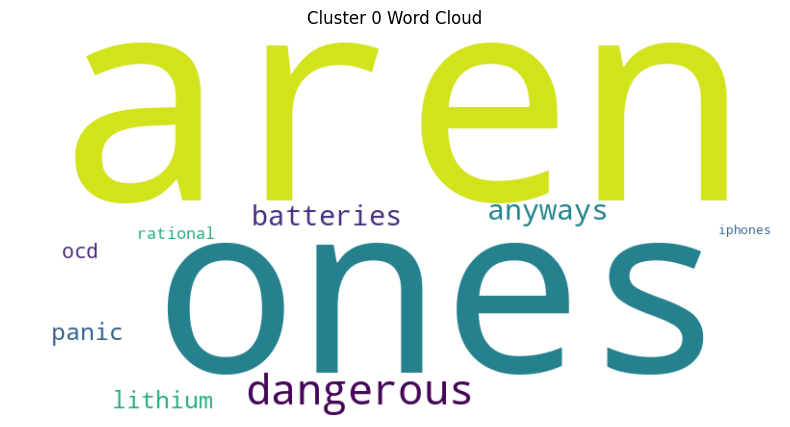

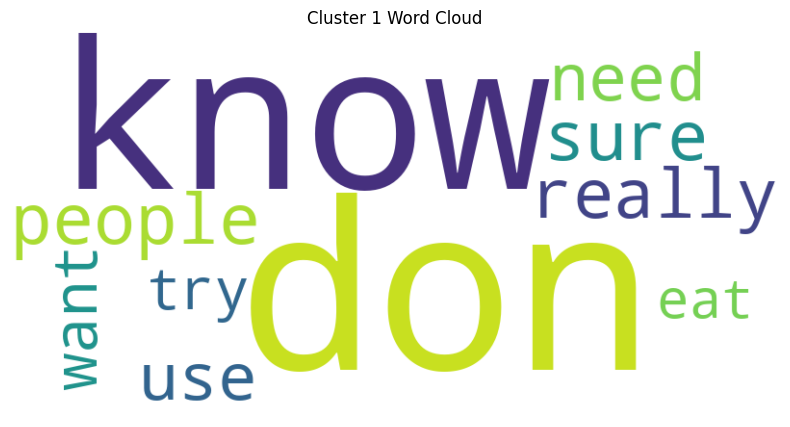

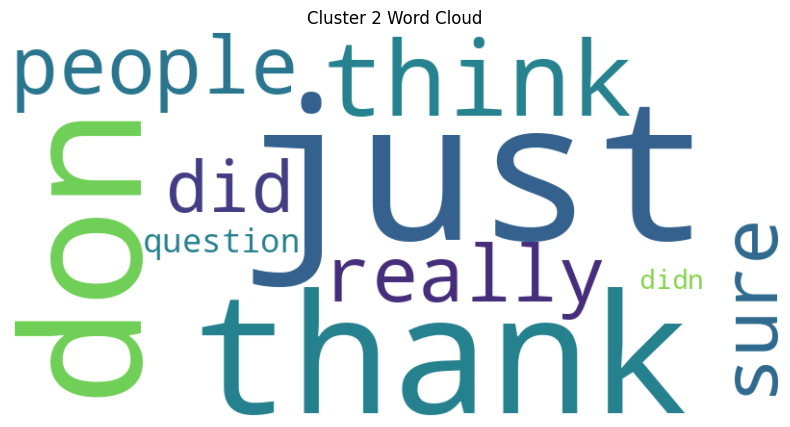

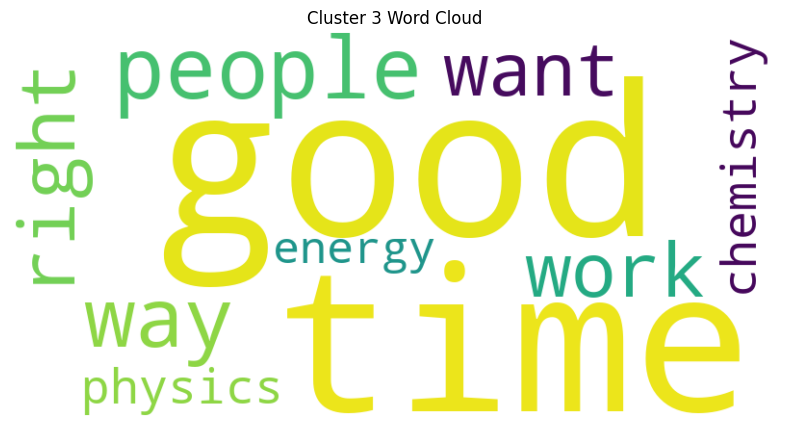

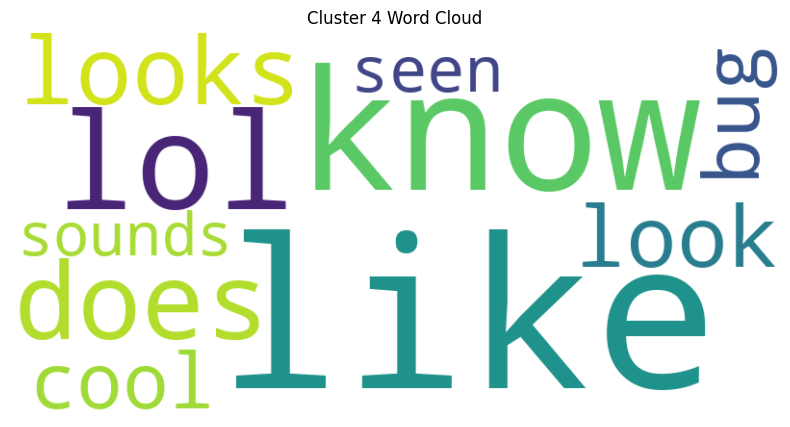

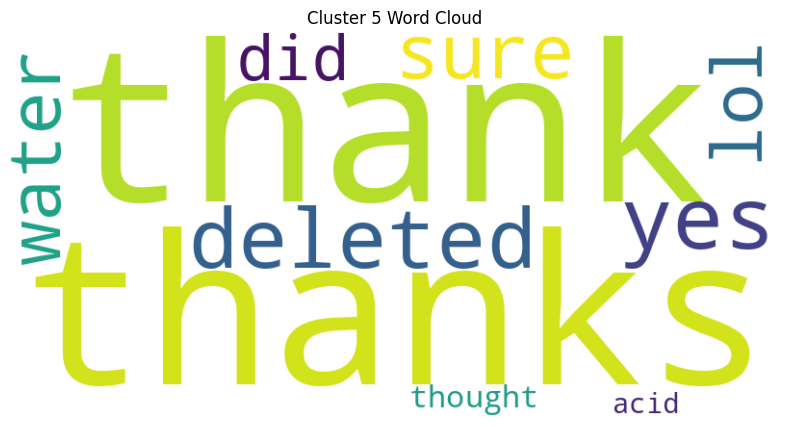

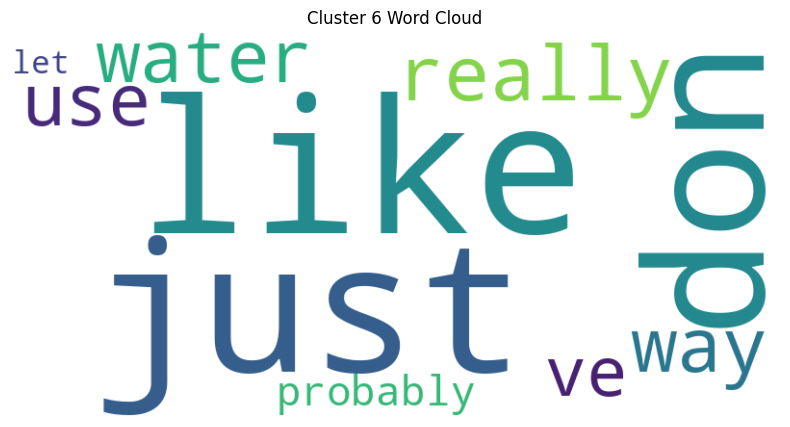

In [34]:
for i in range(number_of_clusters):
    # Get the indices of the top terms in the cluster
    top_indices = model.cluster_centers_.argsort()[i, ::-1][:10]
    
    # Get the feature names from the vectorizer
    feature_names = vectorizer.get_feature_names_out()
    
    # Create a dictionary of term frequencies in the cluster
    wordcloud_dict = {feature_names[ind]: X[:, ind].sum() for ind in top_indices}
    
    # Create and plot the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_dict)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {i} Word Cloud')
    plt.axis('off')
    plt.show()

### Cluster 0: Kebanyakan membahas mengenai gadget (iphone, lithium) yang dicampur dengan mental seperti ocd rational
### Cluster 1: Kebanyakan membahas mengenai pengalaman seseorang
### Cluster 2: Membahas hal yang berhubungan dengan gratitude
### Cluster 3: Kebanyakan membahas hal tentang fisika
### Cluster 4: Kebanyakan membahas sesuatu yang bisa dilihat
### Cluster 5: Cluster kurang jelas dengan apa yang dibahas
### Cluster 6: Cluster kurang jelas dengan apa yang dibahas